### Primero redimensionamos las imágenes a 1024 para eliminar el ruido que se generó 
Todo este fichero se ejecuta con los datos en el disco duro interno, ya que, vamos a trabajar con un mayor volumen de datos y el externo retrasaría la carga de los datos.

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os import scandir, getcwd
import pickle
import pandas as pd
import random
import re
import shutil

In [110]:
# Leemos los archivos pickle donde están las imágenes
listImgTrain = []
with open("listImgTrain.pickle", "rb") as f:
    listImgTrain = pickle.load(f)

listImgVal = []
with open("listImgVal.pickle", "rb") as f:
    listImgVal = pickle.load(f)

Tenemos en una carpeta todas las imágenes del Dataset A y Dataset B juntas. Las redimensionamos y las ponemos en carpetas en función de si será para Train o Val.

In [61]:
#Redimensionamos todas las imagenes a 1024
for img in listImgTrain:
    redim = Image.open("Dataset/Imagenes/"+img)
    nuevo = redim.resize((1024, 1024), Image.ANTIALIAS)
    nuevo.save("Dataset/img 1024/Train/"+img)

In [11]:
for img in listImgVal:
    redim = Image.open("Dataset/Imagenes/"+img)
    nuevo = redim.resize((1024, 1024), Image.ANTIALIAS)
    nuevo.save("Dataset/img 1024/Validation/"+img)

### Concatenación de los CSV
Ahora vamos a concatenar los CSV con el mapeado. Obteniendo un CSV de Train y un CSV de Val.

In [6]:
#Vamos a cargar todos los CSV creados por el Programa de Java para mapear las imágenes.
def lsCSV(ruta = getcwd()):
    return[arch.name for arch in scandir(ruta) if (arch.is_file() and arch.name.endswith('.csv'))]

listCSVTrain = lsCSV("D:\Plasticos\Dataset\CSV train 2048")
listCSVVal = lsCSV("D:\Plasticos\Dataset\CSV val 2048")
print(len(listCSVTrain))
print(len(listCSVVal))


45
17


In [9]:
#Concatenamos todos los CSV y obtenemos el mapeado de todas las imagenes en un mismo dataframe
dfConcatTrain = pd.read_csv("Dataset/CSV train 2048/" + listCSVTrain[0])
for i in listCSVTrain[1:]:
    dfNew = pd.read_csv("Dataset/CSV train 2048/" + i)
    dfConcatTrain = pd.concat([dfConcatTrain,dfNew],ignore_index=True)

dfConcatTrain.count()
#Guardar
#dframe.to_csv("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/CSV 16x16 Java/DatosImgTODOS.csv", header=True, index=False)

Nombre Segmento    184320
Plasticos          184320
dtype: int64

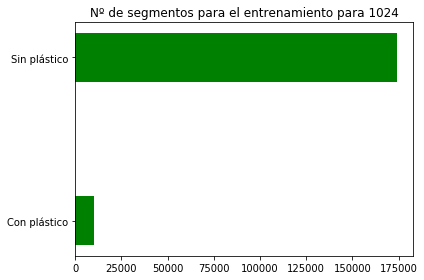

Segmentos con plástico:  10108
Segmentos sin plasticos:  174212


In [10]:
def visualizarClases(dfConcat, title, ruta):
    #Contamos cuantos fragmentos tenemos con/sin plásticos
    unos = dfConcat[dfConcat['Plasticos'] == 1].count()
    ceros = dfConcat[dfConcat['Plasticos'] == 0].count()

    #Graficos de barras bonicos ---> https://plot.ly/matplotlib/bar-charts/
    plt.barh(["Con plástico","Sin plástico"],[unos.values[0],ceros.values[0]],color="Green",height=0.3)
    plt.title(title)
    plt.tight_layout() #Evitamos que se corten las leyendas del gráfico con size también se arregla
    plt.savefig(ruta, pad_inches=30)
    plt.show()
    
    print("Segmentos con plástico: ", unos[0])
    print("Segmentos sin plasticos: ", ceros[0])
    
visualizarClases(dfConcatTrain,"Nº de segmentos para el entrenamiento para 1024","NSegmentosImg-1024Train.jpg")

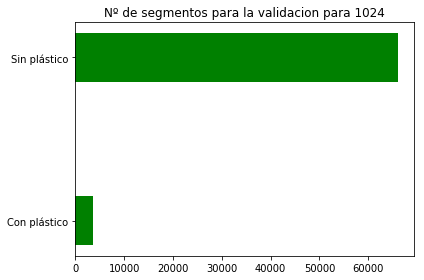

Segmentos con plástico:  3532
Segmentos sin plasticos:  66100


In [11]:
#Concatenamos todos los CSV y obtenemos el mapeado de todas las imagenes en un mismo dataframe
dfConcatVal = pd.read_csv("Dataset/CSV val 2048/" + listCSVVal[0])
for i in listCSVVal[1:]:
    dfNew = pd.read_csv("Dataset/CSV val 2048/" + i)
    dfConcatVal = pd.concat([dfConcatVal,dfNew],ignore_index=True)

dfConcatVal.count()
visualizarClases(dfConcatVal,"Nº de segmentos para la validacion para 1024","NSegmentosImg-1024Val.jpg")

#Guardamos el CSV con los datos
dfConcatVal.to_csv("Dataset/seg 1024/ValTODOS.csv", header=True, index=False)

In [111]:
#CSV FORMATEADOS DE ABAJO
dfTrain = pd.read_csv("Dataset/seg 2048/TrainTODOS-Format.csv")
dfVal = pd.read_csv("Dataset/seg 2048/ValTODOS-Format.csv")

### Segmentamos las imágenes

In [113]:
n = int(1024/16) #64
unosListTrain = dfTrain[dfTrain['Plasticos'] == 1]['Nombre Segmento'].tolist() #Los nombres no están del todo bien
#Para reestructurar la imagen
print("Len de unosListTrain: " ,len(unosListTrain))

listaUnosTrain = [] #Con los nombres de los segmentos tipo 01 y 04 (2 digitos)

for img in listImgTrain:
    recort = Image.open("Dataset/img 1024/Train/"+img)
    for i in range(0,n):
        for j in range(0,n):
            region = recort.crop((i*16,j*16,i*16+16,j*16+16))
            subtring = img[0:-4]
            seg = "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)
            if seg in unosListTrain:
                region.save("Dataset/seg 1024/Train/plastico/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
                listaUnosTrain.append("imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
            else:
                region.save("Dataset/seg 1024/Train/arena/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
            

len(listaUnosTrain)

Len de unosListTrain:  80864


10108

In [131]:
n = int(1024/16) #64
unosListVal = dfVal[dfVal['Plasticos'] == 1]['Nombre Segmento'].tolist() #Los nombres no están del todo bien
#Para reestructurar la imagen
print("Len de unosListVal: ",len(unosListVal))


for img in listImgVal:
    recort = Image.open("Dataset/img 1024/Validation/"+img)
    for i in range(0,n):
        for j in range(0,n):
            region = recort.crop((i*16,j*16,i*16+16,j*16+16))
            subtring = img[0:-4]
            seg = "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)
            
            #Los guardamos también en la carpeta Predict para la matriz de confusión
            region.save("Dataset/seg 1024/Predict/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")

            if seg in unosListVal:
                region.save("Dataset/seg 1024/Validation/plastico/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
            else:
                region.save("Dataset/seg 1024/Validation/arena/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")


Len de unosListVal:  3532


### Data augmentation de los segmentos con plástico para Train 
Mismas trasformaciones que en las otras pruebas

In [115]:
prueba = listaUnosTrain[0]
print(prueba)
print((prueba[:-11] +"-DA_a"+ prueba[-11:len(prueba)]))

imgID-1-R05C54.jpg
imgID-1-DA_a-R05C54.jpg


In [116]:
#Bucle for para realizar el Data Augmentation
listNewImg = []
for i in listaUnosTrain:
    imagenOriginal = Image.open("Dataset/seg 1024/Train/plastico/"+i)

    imagen90 = imagenOriginal.transpose(Image.ROTATE_90)
    listNewImg.append(i[:-11] +"-DA_a"+ i[-11:len(i)])
    imagen90.save("Dataset/seg 1024/Train/plastico/"+i[:-11] +"-DA_a"+ i[-11:len(i)])
    
    imagen180 = imagenOriginal.transpose(Image.ROTATE_180)
    listNewImg.append(i[:-11] +"-DA_b"+ i[-11:len(i)])
    imagen180.save("Dataset/seg 1024/Train/plastico/"+i[:-11] +"-DA_b"+ i[-11:len(i)])
    
    imagen270 = imagenOriginal.transpose(Image.ROTATE_270)
    listNewImg.append(i[:-11] +"-DA_c"+ i[-11:len(i)])
    imagen270.save("Dataset/seg 1024/Train/plastico/"+i[:-11] +"-DA_c"+ i[-11:len(i)])
    
    imagenTOPMirror = imagenOriginal.transpose(Image.FLIP_TOP_BOTTOM)
    listNewImg.append(i[:-11] +"-DA_d"+ i[-11:len(i)])
    imagenTOPMirror.save("Dataset/seg 1024/Train/plastico/"+i[:-11] +"-DA_d"+ i[-11:len(i)])
    
    imagenLEFTMirror = imagenOriginal.transpose(Image.FLIP_LEFT_RIGHT)
    listNewImg.append(i[:-11] +"-DA_e"+ i[-11:len(i)])
    imagenLEFTMirror.save("Dataset/seg 1024/Train/plastico/"+i[:-11] +"-DA_e"+ i[-11:len(i)])
    
    imagenTRANSVERSE = imagenOriginal.transpose(Image.TRANSVERSE)
    listNewImg.append(i[:-11] +"-DA_f"+ i[-11:len(i)])
    imagenTRANSVERSE.save("Dataset/seg 1024/Train/plastico/"+i[:-11] +"-DA_f"+ i[-11:len(i)])
    
    imagenTRANSPOSE = imagenOriginal.transpose(Image.TRANSPOSE)
    listNewImg.append(i[:-11] +"-DA_g"+ i[-11:len(i)])
    imagenTRANSPOSE.save("Dataset/seg 1024/Train/plastico/"+i[:-11] +"-DA_g"+ i[-11:len(i)])
    

print(len(listNewImg))

70756


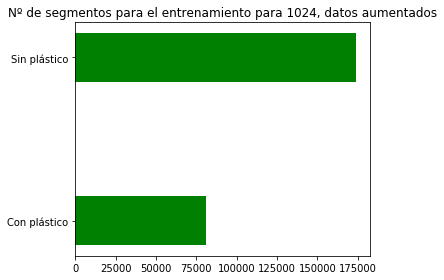

Segmentos con plástico:  80864
Segmentos sin plasticos:  174212


Nombre Segmento    255076
Plasticos          255076
dtype: int64

In [32]:
#Concatenamos los datos del CSV de Train + el Data augmentation
listNewImgUnos = np.ones(len(listNewImg),dtype=int)
dframeTrain = pd.DataFrame({"Nombre Segmento":listNewImg, "Plasticos":listNewImgUnos}) 
dframeTrain = pd.concat([dfConcatTrain,dframeTrain],ignore_index=True)

visualizarClases(dframeTrain,"Nº de segmentos para el entrenamiento para 1024, datos aumentados","NSegmentosImg-1024TrainAug.jpg")
dframeTrain.count()

In [34]:
#Guardamos el CSV con los datos
dframeTrain.to_csv("Dataset/seg 1024/TrainTODOS.csv", header=True, index=False)

### Formatear bien el CSV (pruebas)

In [94]:
string = "imgID6-R3C17.jpg"
newString = string.replace('imgID', 'imgID-')
newString = string.replace('--', '-')
newString = string.replace('.jpg', '')
newString

'imgID6-R3C17'

In [81]:
import re
patron = re.compile('(R([0-9]*))(C([0-9]*))')
print(patron.search(string))
matcher = patron.search(string)
print(matcher.group(0))
print(matcher.group(1))
print(matcher.group(2))
print(matcher.group(3))
print(matcher.group(4))
print(matcher.groups())


<_sre.SRE_Match object; span=(7, 12), match='R3C17'>
R3C17
R3
3
C17
17
('R3', '3', 'C17', '17')


In [83]:
r = int(matcher.group(2))
c = int(matcher.group(4))
ejemplo = patron.sub("R{0:0=2d}".format(r)+ "C{0:0=2d}".format(c), string) 
print(ejemplo)
print(type(ejemplo))

imgID6-R03C17
<class 'str'>


In [62]:
#Ejemplo de internet
patron = re.compile('([ab])([3-5]+)') # ahora la letra se capturará en el grupo 1, y los números en el 2
matcher = patron.search('a455 a333b435')
print(matcher.group(0)) # el grupo 0 es el trozo de cadena que coincidió con el patrón completo 'a455' 
print(matcher.group(1)) #  'a' 

patron.sub("X", 'a455 a333b435') # sustituye todas las ocurrencias por X 'X XX' 
patron.sub("LETRA(\g<1>), NUMERO(\g<2>)", 'a455 a333b435') 
# El reemplazo depende de lo que se capture LETRA(a), NUMERO(455) LETRA(a), NUMERO(333)LETRA(b), NUMERO(435)'

a455
a


'LETRA(a), NUMERO(455) LETRA(a), NUMERO(333)LETRA(b), NUMERO(435)'

### Formatear bien el CSV (proceso)

In [29]:
#Cargamos el CSV con TODOS:
dframeTrain = pd.read_csv("Dataset/seg 1024/TrainTODOS.csv")
dframeVal = pd.read_csv("Dataset/seg 1024/ValTODOS.csv")

In [32]:
#Corregimos todas las discordancias que hay entre los nombres de los segmentos
#Algunos con "-", otros con el ".jpg", otros con solo un digito en R y C.
patron = re.compile('(R([0-9]*))(C([0-9]*))')
count = 0
colum1List = dframeTrain['Nombre Segmento'].tolist()
colum2List = dframeTrain['Plasticos'].tolist()

for i in range(len(colum1List)):
    count = count+1
    string = colum1List[i]
    newString = string.replace('imgID', 'imgID-')
    newString = newString.replace('--', '-')
    newString = newString.replace('.jpg', '')
    
    matcher = patron.search(newString)
    r = int(matcher.group(2))
    c = int(matcher.group(4))
    newString = patron.sub("R{0:0=2d}".format(r)+ "C{0:0=2d}".format(c), newString)
    
    #Actualizamos el valor
    colum1List[i] = newString
    if(count%1000 == 0):
        print(count, end = ' ')


1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 15

In [33]:
dframeTrain = pd.DataFrame({'Nombre Segmento': colum1List, 'Plasticos': colum2List})
dframeTrain.head(2)

Nombre Segmento  Plasticos
0  imgID-10-R00C00          0
1  imgID-10-R00C01          0

In [34]:
#Guardamos el CSV con los datos
dframeTrain.to_csv("Dataset/seg 1024/TrainTODOS-Format.csv", header=True, index=False)

In [35]:
#Lo mismo para dfConcatVal
patron = re.compile('(R([0-9]*))(C([0-9]*))')
count = 0
colum1List = dframeVal['Nombre Segmento'].tolist()
colum2List = dframeVal['Plasticos'].tolist()

for i in range(len(colum1List)):
    count = count+1
    string = colum1List[i]
    newString = string.replace('imgID', 'imgID-')
    newString = newString.replace('--', '-')
    
    matcher = patron.search(newString)
    r = int(matcher.group(2))
    c = int(matcher.group(4))
    newString = patron.sub("R{0:0=2d}".format(r)+ "C{0:0=2d}".format(c), newString)
    
    #Actualizamos el valor
    colum1List[i] = newString
    if(count%1000 == 0):
        print(count, end = ' ')
    

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 

In [36]:
dframeVal = pd.DataFrame({'Nombre Segmento': colum1List, 'Plasticos': colum2List})
dframeVal.head(2)

Nombre Segmento  Plasticos
0  imgID-20151115_Lambra_b-R00C00          0
1  imgID-20151115_Lambra_b-R00C01          0

In [37]:
#Guardamos el CSV con los datos
dframeVal.to_csv("Dataset/seg 1024/ValTODOS-Format.csv", header=True, index=False)

### Preparacion de los datos para la Red

In [117]:
unosList = dfTrain[dfTrain['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dfTrain[dfTrain['Plasticos'] == 0]['Nombre Segmento'].tolist()
print("Imágenes con plásticos: ", len(unosList))
print("Imágenes sin plásticos: ", len(cerosList))

random.shuffle(cerosList)
random.shuffle(unosList)
mover = cerosList[len(unosList):]
cerosList = cerosList[:len(unosList)]
print("Ahora igualamos el nº de elementos: \ncerosList = ", len(cerosList))

Imágenes con plásticos:  80864
Imágenes sin plásticos:  174212
Ahora igualamos el nº de elementos: 
cerosList =  80864


In [118]:
for i in mover:
    shutil.move("Dataset/seg 1024/Train/arena/"+i+".jpg", "Dataset/seg 1024/Train arena extra")


In [119]:
#Preparamos el conjunto de Validación
unosList = dfVal[dfVal['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dfVal[dfVal['Plasticos'] == 0]['Nombre Segmento'].tolist()
print("Imágenes con plásticos: ", len(unosList))
print("Imágenes sin plásticos: ", len(cerosList))

random.shuffle(cerosList)
random.shuffle(unosList)
mover = cerosList[len(unosList):]
cerosList = cerosList[:len(unosList)]
print("Ahora igualamos el nº de elementos: \ncerosList = ", len(cerosList))

Imágenes con plásticos:  3532
Imágenes sin plásticos:  66100
Ahora igualamos el nº de elementos: 
cerosList =  3532


In [120]:
for i in mover:
    shutil.move("Dataset/seg 1024/Validation/arena/"+i+".jpg", "Dataset/seg 1024/Val arena extra")

## Red Neuronal

In [121]:
from keras.models                import Sequential, Model
from keras.layers                import Dense, Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.layers                import Conv2DTranspose, UpSampling2D, MaxPooling2D, Reshape, Activation, ReLU
from keras.preprocessing.image   import ImageDataGenerator
from keras.utils                 import to_categorical
from keras.optimizers            import SGD
from keras.callbacks             import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image   import ImageDataGenerator

In [122]:
#Creamos datos
datagen = ImageDataGenerator(rescale=1./255)
Train_directory = datagen.flow_from_directory("Dataset/seg 1024/Train", target_size=(16, 16), batch_size=32, class_mode='binary')

datagen2 = ImageDataGenerator(rescale = 1./255)
Val_directory = datagen2.flow_from_directory("Dataset/seg 1024/Validation",target_size=(16, 16), batch_size=32, class_mode='binary')

Found 161728 images belonging to 2 classes.
Found 7064 images belonging to 2 classes.


In [123]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(16, 16, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Flatten())  
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [124]:
#Primero entrenamos con los datos separados con sklearn
model_checkpoint = ModelCheckpoint('RedPesos-1024.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
history = model.fit_generator(Train_directory, steps_per_epoch=20, epochs=30, validation_data=Val_directory, validation_steps=10, callbacks=[model_checkpoint])

Epoch 1/30
20/20 [==============================] - 29s 1s/step - loss: 0.6962 - acc: 0.5188 - val_loss: 0.6893 - val_acc: 0.5437

Epoch 00001: val_loss improved from inf to 0.68935, saving model to RedPesos-1024.hdf5
Epoch 2/30
20/20 [==============================] - 29s 1s/step - loss: 0.6939 - acc: 0.5094 - val_loss: 0.6900 - val_acc: 0.4906

Epoch 00002: val_loss did not improve from 0.68935
Epoch 3/30
20/20 [==============================] - 19s 939ms/step - loss: 0.6863 - acc: 0.5156 - val_loss: 0.6888 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.68935 to 0.68878, saving model to RedPesos-1024.hdf5
Epoch 4/30
20/20 [==============================] - 19s 931ms/step - loss: 0.6805 - acc: 0.5703 - val_loss: 0.6843 - val_acc: 0.5656

Epoch 00004: val_loss improved from 0.68878 to 0.68429, saving model to RedPesos-1024.hdf5
Epoch 5/30
20/20 [==============================] - 20s 998ms/step - loss: 0.6733 - acc: 0.6250 - val_loss: 0.6643 - val_acc: 0.5813

Epoch 00005: val

In [137]:
#Volvemos a entrenar a ver si mejora
model_checkpoint = ModelCheckpoint('RedPesos-1024-2time.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(Train_directory, steps_per_epoch=20, epochs=20, validation_data=Val_directory, validation_steps=10, callbacks=[model_checkpoint])

Epoch 1/20
20/20 [==============================] - 55s 3s/step - loss: 0.4867 - acc: 0.7812 - val_loss: 0.5686 - val_acc: 0.7094

Epoch 00001: loss improved from inf to 0.48668, saving model to RedPesos-1024-2time.hdf5
Epoch 2/20
20/20 [==============================] - 44s 2s/step - loss: 0.4871 - acc: 0.7578 - val_loss: 0.4825 - val_acc: 0.7500

Epoch 00002: loss did not improve from 0.48668
Epoch 3/20
20/20 [==============================] - 40s 2s/step - loss: 0.5325 - acc: 0.7344 - val_loss: 0.5833 - val_acc: 0.6781

Epoch 00003: loss did not improve from 0.48668
Epoch 4/20
20/20 [==============================] - 38s 2s/step - loss: 0.4975 - acc: 0.7469 - val_loss: 0.5808 - val_acc: 0.6875

Epoch 00004: loss did not improve from 0.48668
Epoch 5/20
20/20 [==============================] - 37s 2s/step - loss: 0.5025 - acc: 0.7594 - val_loss: 0.5510 - val_acc: 0.6937

Epoch 00005: loss did not improve from 0.48668
Epoch 6/20
20/20 [==============================] - 36s 2s/step - lo

In [138]:
#Cargamos los pesos del modelo
model.load_weights('RedPesos-1024-2time.hdf5')   

In [88]:
from sklearn.metrics import confusion_matrix

unosList = dframeVal[dframeVal['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dframeVal[dframeVal['Plasticos'] == 0]['Nombre Segmento'].tolist()

X_test = unosList + cerosList
Y_test = np.concatenate([np.ones((len(unosList),),dtype=int),np.zeros((len(cerosList),),dtype=int)])

model.evaluate_generator(Val_directory)
#pv_round = np.asarray([int(round(i)) for i in pv])
#conf_mat = confusion_matrix(Y_test, pv_round)
#conf_mat

[0.6935683291063708, 0.49999999993249755]

### Matriz de confusión

In [139]:
X_testList = dfVal['Nombre Segmento'].tolist()

X_test = np.array([np.array(Image.open("Dataset/seg 1024/Predict/"+img + ".jpg")) for img in X_testList] )
print(X_test.shape)

(69632, 16, 16, 3)


In [140]:
X_test= X_test / 255.0

In [141]:
unosList = dfVal[dfVal['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dfVal[dfVal['Plasticos'] == 0]['Nombre Segmento'].tolist()

Y_test = np.zeros((len(X_testList)))
for i in range(len(Y_test)):
    if X_testList[i] in unosList : 
        Y_test[i] = 1

print(len(Y_test))

69632


In [142]:
pv =  np.ravel(model.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
conf_mat

array([[51093, 15007],
       [  921,  2611]], dtype=int64)

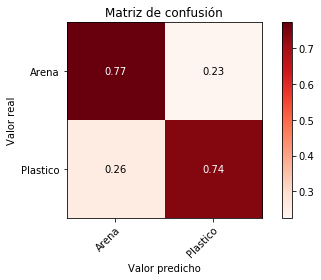

In [143]:
def matrixConfusion (conf_mat, cmap):
    
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]),
            yticks=np.arange(conf_mat.shape[0]),
            xticklabels=["Arena","Plastico"], yticklabels=["Arena","Plastico"],
            title='Matriz de confusión',
            ylabel='Valor real',
            xlabel='Valor predicho')
    
    # Rotate the tick labels and set their alignment.    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("MatrizConfusion-1024-2time.jpg")
    
    plt.show()
    
matrixConfusion(conf_mat,'Reds')

### Visualizar IMG con predict

In [89]:
from keras.models                import Sequential, Model
from keras.layers                import Dense, Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.layers                import Conv2DTranspose, UpSampling2D, MaxPooling2D, Reshape, Activation, ReLU
from keras.preprocessing.image   import ImageDataGenerator
from keras.utils                 import to_categorical
from keras.optimizers            import SGD
from keras.callbacks             import ModelCheckpoint, LearningRateScheduler

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from os import scandir, getcwd

In [90]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(16, 16, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Flatten())  
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [144]:
#Cargamos los pesos del modelo
model.load_weights('RedPesos-1024-2time.hdf5')   

In [146]:
def lsTestIMG(imgName, ruta = getcwd()):
    return [arch.name for arch in scandir(ruta) if (arch.is_file() and arch.name.endswith('.jpg') 
                                                    and arch.name.startswith(imgName[0:-4]))] 
def segmentarImg(img):
    n = int(1024/16) 
    listaRegionesTest = []
    recort = Image.open("Dataset/img 1024/Test/"+img)
    for i in range(0,n):
        for j in range(0,n):
            region = recort.crop((i*16,j*16,i*16+16,j*16+16))
            subtring = img[0:-4]
            region.save("Dataset/seg 1024/Test/"+
                        "imgID-"+subtring+"-R"+"{0:0=3d}".format(i)+"C"+"{0:0=3d}".format(j)+".jpg")
            listaRegionesTest.append("imgID-"+subtring+"-R"+"{0:0=3d}".format(i)+"C"+"{0:0=3d}".format(j)+".jpg")
    return listaRegionesTest
    
def evaluarVisualizarIMG(imagenPaVer):
    
    n = int(1024/16)
    
    listNuevasPruebas = lsTestIMG("imgID-"+imagenPaVer,
                                  "Dataset/seg 1024/Test/")
    
    #Hay que segmentarla si no está segmentada o faltan segmentos
    if (not listNuevasPruebas) or (len(listNuevasPruebas)<n*n):
        listNuevasPruebas = segmentarImg(imagenPaVer)
        
    arrayNuevasPruebas = np.array([np.array(
                            Image.open("Dataset/seg 1024/Test/"+img)) 
                                   for img in listNuevasPruebas])
    arrayNuevasPruebas = arrayNuevasPruebas / 255.0

    evalNuevasPruebas =  np.ravel(model.predict(arrayNuevasPruebas))
    
    print(type(evalNuevasPruebas))
    print(evalNuevasPruebas.shape)
    
    
    evalNuevasPruebas = np.asarray([int(round(i)) for i in evalNuevasPruebas])
    counterNuevasPruebas = np.count_nonzero(evalNuevasPruebas)
    
            
    listVisual = np.asarray(listNuevasPruebas).reshape((n,n))
    evalVisual = evalNuevasPruebas.reshape((n, n))
    fondo = Image.new('RGBA', (1024, 1024), "black") 
    mask = Image.new('RGBA', (1024, 1024), "black") 
    blanco = Image.new('RGBA', (16, 16), "white")
    
    for i in range(0,n):
        for j in range(0,n):
            if evalVisual[i][j] == 1:
                imagen = Image.open("Dataset/seg 1024/Test/"+listVisual[i][j])
                fondo.paste(imagen,(i*16,j*16))
                mask.paste(blanco,(i*16,j*16))
    
    fondo.save("%s_predict.png" %imagenPaVer[0:-4])
    mask.save("%s_mask.png"  %imagenPaVer[0:-4])  
    
    plt.figure(figsize=(15,15))
    plt.subplot(111)
    plt.axis('off')
    plt.title(imagenPaVer)
    array = np.array(fondo)
    plt.imshow(array) 

<class 'numpy.ndarray'>
(4096,)


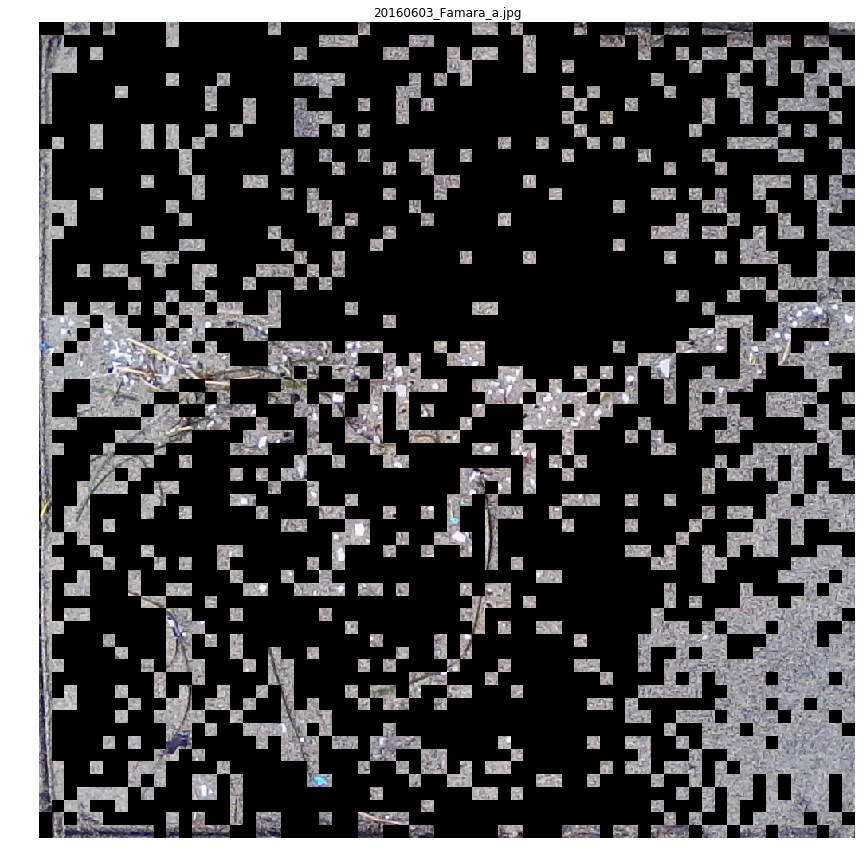

In [147]:
evaluarVisualizarIMG("20160603_Famara_a.jpg")

<class 'numpy.ndarray'>
(4096,)


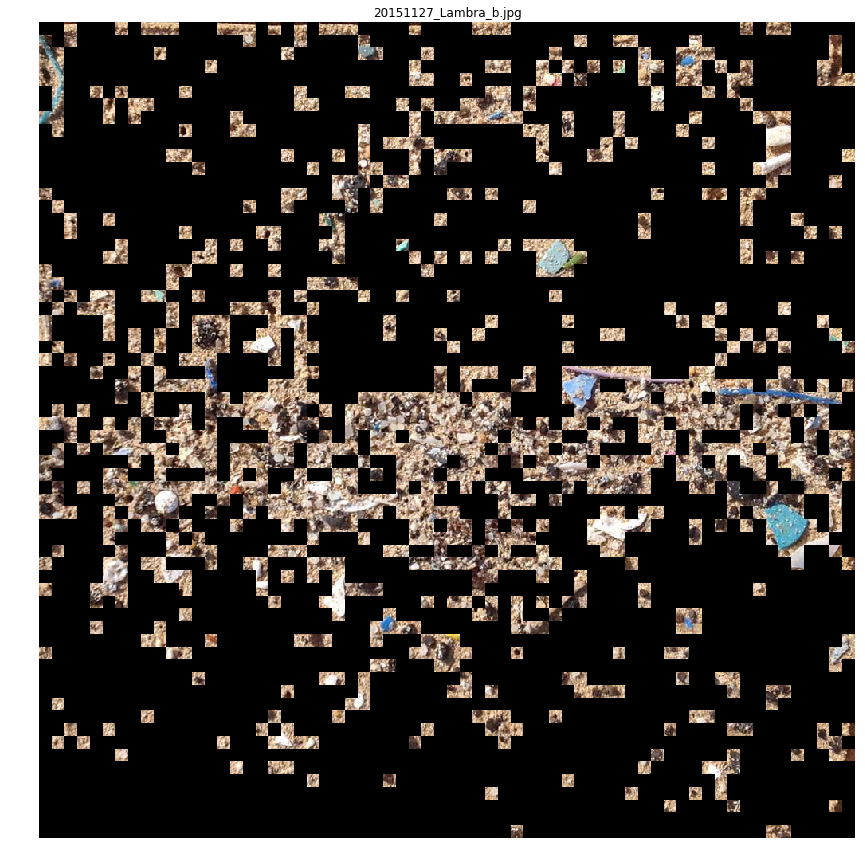

In [148]:
evaluarVisualizarIMG("20151127_Lambra_b.jpg")

<class 'numpy.ndarray'>
(4096,)


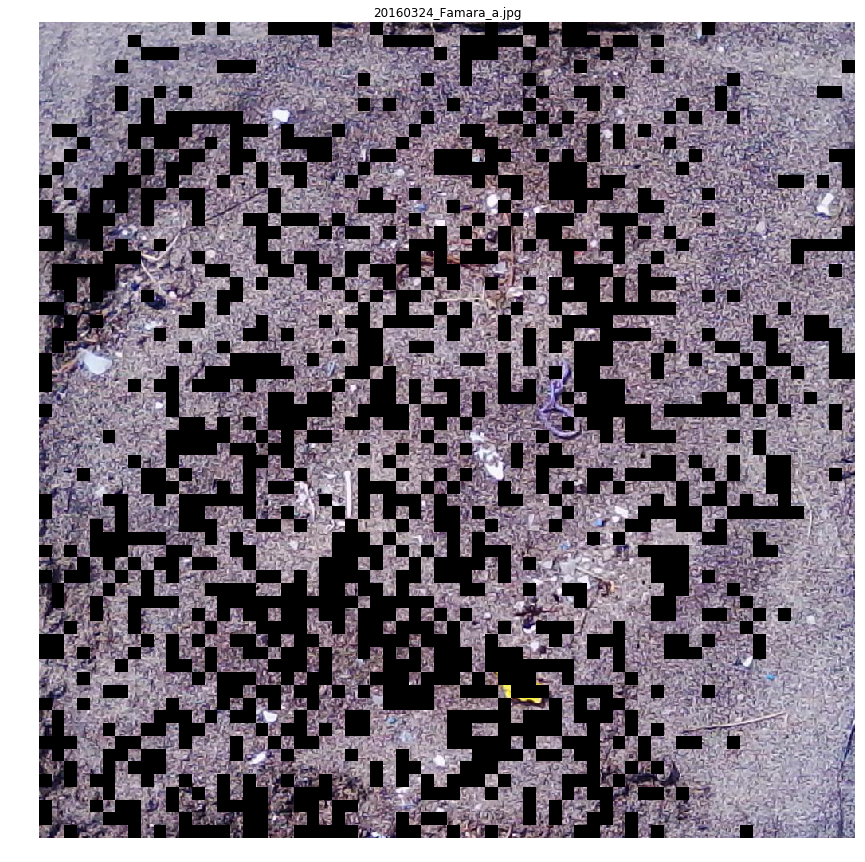

In [149]:
evaluarVisualizarIMG("20160324_Famara_a.jpg")

<class 'numpy.ndarray'>
(4096,)


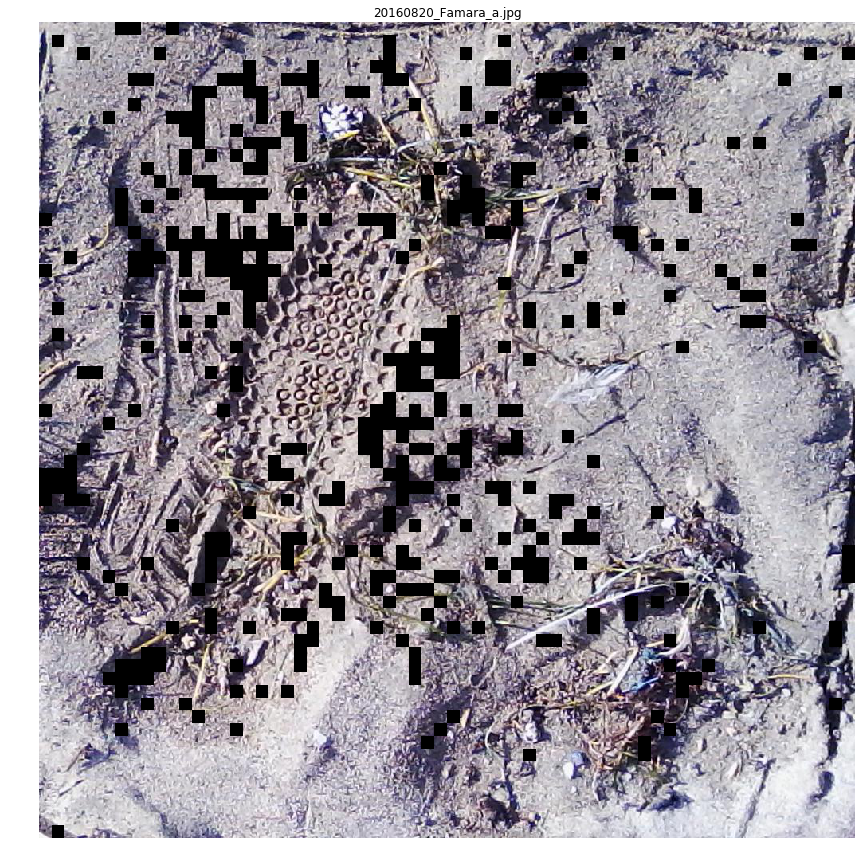

In [150]:
evaluarVisualizarIMG("20160820_Famara_a.jpg")

<class 'numpy.ndarray'>
(4096,)


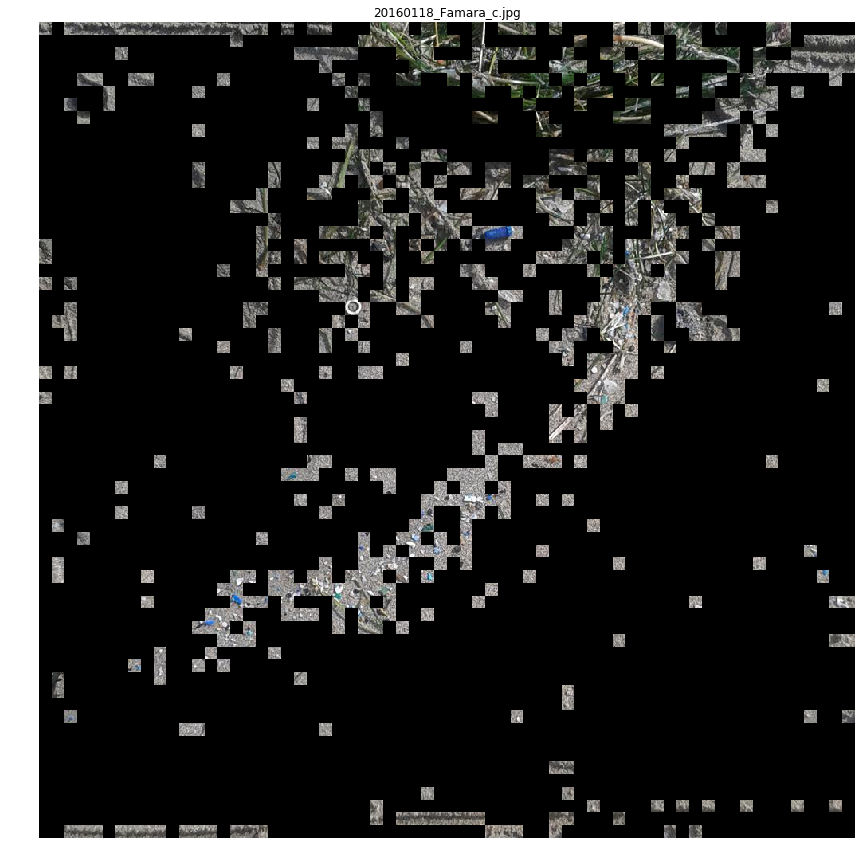

In [151]:
evaluarVisualizarIMG("20160118_Famara_c.jpg")

<class 'numpy.ndarray'>
(4096,)


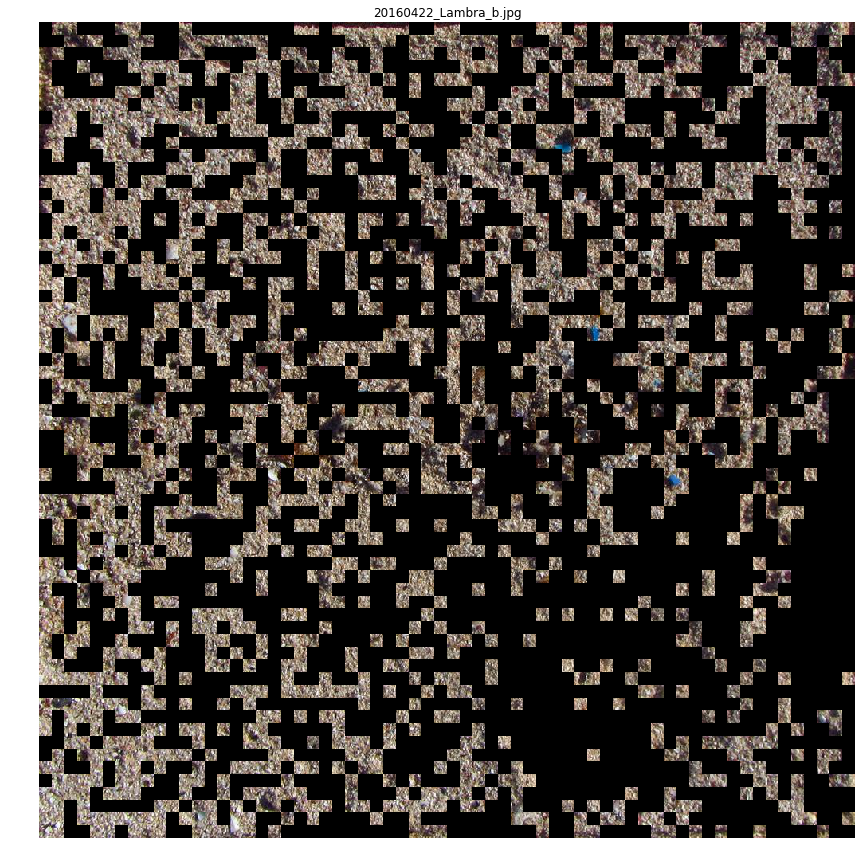

In [152]:
evaluarVisualizarIMG("20160422_Lambra_b.jpg")